In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import numpy as np
import statsmodels.api as sm
from scipy import fft, fftpack
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False

In [ ]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib inline

# Data preparation #
In this section the data is prepared for analysis 

In [ ]:
data = pd.read_csv("../../data/merged_data.csv").drop(columns=['tmz'])

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data['dayofweek'] = data.date.dt.dayofweek

In [ ]:
#interval of dates in the dataset
date_range = pd.date_range(start=data.date.min().date(), end=data.date.max().date())

In [ ]:
# number of requests made on a specific date for a specific link
hash_count_by_day = data.groupby(['hash', 'date'], sort=True).size()
# number of requests made on a specific date in a specific hour for a specific link
hash_count_by_hour = data.groupby(['hash', 'date','hours'], sort=True).size()

In [ ]:
# number of requests made on a specific date
daily_size = data.groupby(['date']).size()

In [ ]:
# The amount of requests made during a specific hour, specific day of the week and specific date
# Date column being dropped as it is made meaningless by ".size()"
# The last column shows the size of each day for each hour, dow
daily_seasonality_size = data.groupby(['hours', 'dayofweek','date'], sort=True).size().reset_index().drop(columns=['date'])
# The average amount of requests made for the combination of dow X hour
daily_seasonality_mean = daily_seasonality_size.groupby(['hours', 'dayofweek']).mean().reset_index()
# The minimum/maximum amount of requests made for the combination of day of the week X hour
# Monday - 3 AM --> X is the smallest/largest number of requests made over all Monday dates in the dataset during the specifed hour
daily_seasonality_max = daily_seasonality_size.groupby(['hours', 'dayofweek']).max().reset_index()
daily_seasonality_min = daily_seasonality_size.groupby(['hours', 'dayofweek']).min().reset_index()

In [ ]:
# The average over all hours on weekends/weekdays
weekend_mean = daily_seasonality_size.query('dayofweek == 5 or dayofweek == 6').groupby(['hours']).mean()
weekday_mean = daily_seasonality_size.query('dayofweek != 5 and dayofweek != 6').groupby(['hours']).mean()
# The average over all hours during the entire week
week_mean = daily_seasonality_size.groupby(['hours']).mean().drop(columns=['dayofweek']).reset_index()
week_mean.columns = ['hours','mean']

In [ ]:
daily_seasonality_mean.columns = ['hours', 'dayofweek','mean']
daily_seasonality_max.columns = ['hours', 'dayofweek','max']
daily_seasonality_min.columns = ['hours', 'dayofweek','min']
weekend_mean.columns = ['dayofweek','mean']
weekday_mean.columns = ['dayofweek','mean']

In [ ]:
# This number decides what requests are considered "reoccuring" (appearing more than the defined number)
not_reoccuring_number = 1

In [ ]:
# Lists unique hashes by total amount of occurances in the dataset
hash_counts = data['hash'].value_counts().sort_values()
# All hashes appearing more than once
reoccuring_hashes_1 = hash_counts[hash_counts > 1]
# All hashes appearing more than ten times
reoccuring_hashes_10 = hash_counts[hash_counts > 10]
# All non-reoccuring requests
not_reoccuring =  hash_counts[hash_counts <= not_reoccuring_number]

In [ ]:
# Defines groups for grouping hashes into intervals by the amount of requests
bins = [0,1,100,1000,10000,25000,50000,100000,20000000]
# The number of requests within specifed interval
hash_counts_groups = pd.cut(hash_counts, bins=bins)
hash_counts_groups = hash_counts_groups.reset_index().groupby(['hash']).size().reset_index()
hash_counts_groups.columns = ['group','count']
hash_counts_groups['group'] = hash_counts_groups['group'].astype(str)

In [ ]:
# True/False of not-reoccuring pandas indexes (hourly, daily)
not_reoccuring_hourly_indexes = hash_count_by_hour.reset_index().hash.isin(not_reoccuring.index)
not_reoccuring_daily_indexes = hash_count_by_day.reset_index().hash.isin(not_reoccuring.index)
# Filtered requests counts hourly/daily
not_reoccuring_hourly = hash_count_by_hour.reset_index()[not_reoccuring_hourly_indexes]
not_reoccuring_daily = hash_count_by_day.reset_index()[not_reoccuring_daily_indexes]

In [ ]:
not_reoccuring_daily = not_reoccuring_daily.groupby('date').sum().reset_index()
not_reoccuring_hourly = not_reoccuring_hourly.groupby(['date','hours']).sum().reset_index()
not_reoccuring_hourly['combined'] = not_reoccuring_hourly['date'].dt.strftime('%Y-%m-%d') + '-' + not_reoccuring_hourly['hours'].apply(str)
# The amount of requests by hour of date
hourly_hash_counts = hash_count_by_hour.reset_index().drop(columns=['hash']).groupby(['date','hours']).sum().reset_index()
hourly_hash_counts['combined'] = hourly_hash_counts['date'].dt.strftime('%Y-%m-%d') + '-' + hourly_hash_counts['hours'].apply(str)
hourly_hash_counts.columns = ['date','hours','count','combined']
not_reoccuring_hourly.columns = ['date','hours','count','combined']
not_reoccuring_daily.columns = ['date','count']

In [ ]:
# hourly_hash_counts modified for plotting
hourly_count = hourly_hash_counts.drop(columns=['date','hours']).set_index(['combined'])

In [17]:
# The number of POST requests
posts = data[data['HTTP'] == 'POST']
posts = posts['hash'].value_counts()
# Post requests made over 10 times
posts_10 = posts[posts > 10]

In [18]:
hash_counts

8ba0fa54d176810286d160ac19909812          1
4b8c6a825f670dbd6fa0e15f6f3fadad          1
13ca7bfa7b077f7345e484105df56e5d          1
71fe0512ad8a07cf92e45e1a981eceaa          1
ecf10d3a2e500d3d36778d176427f891          1
                                     ...   
4e395735b02fc10b9ffc1ca9c28c984f    3201263
d03517f419b520bed290a38e43f578d5    3854028
2221cfb0cf91af74b0122f102e6ae3ff    6907003
e93fa2ab48a1d7f395028dbb379c406b    7081402
60940bbf1a3b82169641ba159686a6ca    9508593
Name: hash, Length: 1791756, dtype: int64

# Data description #
This section attempts to give an general overivew of the data

In [20]:
print(data.date.max().date())
print(data.date.min().date())
print((data.date.max() - data.date.min()).days)

2019-08-06
2019-06-12
55


The dataset covers dates from 12.06.2019 to 06.08.2019

In [21]:
print(f'POST requests: {len(posts)}')
print(f'POSTs with at least 10 requests: {len(posts_10)}')
print(f'POST requests %: {100*(len(posts)/len(hash_counts))}')

POST requests: 14862
POSTs with at least 10 requests: 26
POST requests %: 0.8294656192026146


In [22]:
print(f'{100*(len(reoccuring_hashes_1)/len(hash_counts))}% of hashes appear more than once')
print(f'{100*(len(reoccuring_hashes_10)/len(hash_counts))}% of hashes appear more than ten times')
print(f'Reoccuring more than once: {len(reoccuring_hashes_1)}')
print(f'Reoccuring more than ten times: {len(reoccuring_hashes_10)}')
print(f'Unique hash URLs: {len(hash_counts)}; {100*(len(hash_counts)/len(data))}% out of all requests')
print(f'All requests: {len(data)}')

33.32903587318809% of hashes appear more than once
3.4774824250623415% of hashes appear more than ten times
Reoccuring more than once: 597175
Reoccuring more than ten times: 62308
Unique hash URLs: 1791756; 2.7568184967092537% out of all requests
All requests: 64993615


## Requests through time

### Entire dataset

Text(0.5, 1.0, 'Residue component')

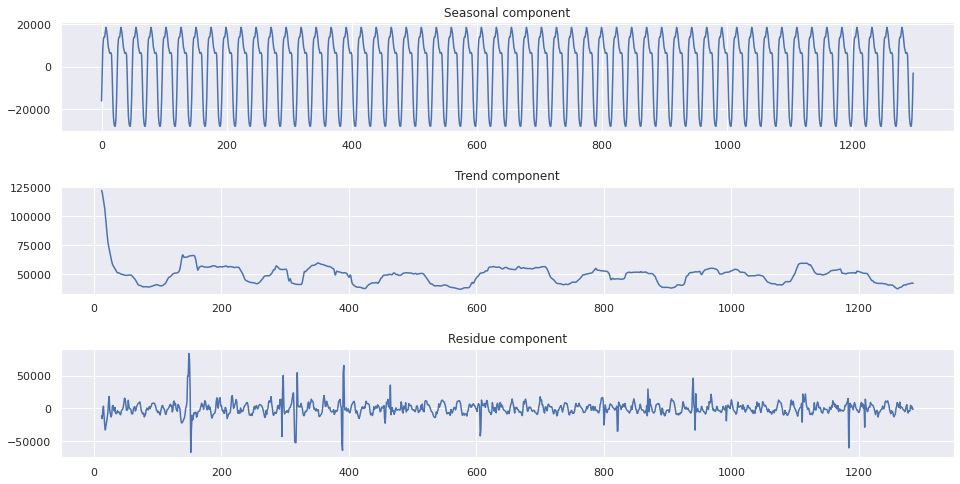

In [68]:
fig, ax = plt.subplots(3, 1)
fig.subplots_adjust(hspace=.5)
fig.set_size_inches(16, 8)
res = seasonal_decompose(hourly_hash_counts['count'].values, period=24, model='additive')
pd.Series(res.seasonal).plot(ax=ax[0])
ax[0].set_title("Seasonal component")
pd.Series(res.trend).plot(ax=ax[1])
ax[1].set_title("Trend component")
pd.Series(res.resid).plot(ax=ax[2])
ax[2].set_title("Residue component")

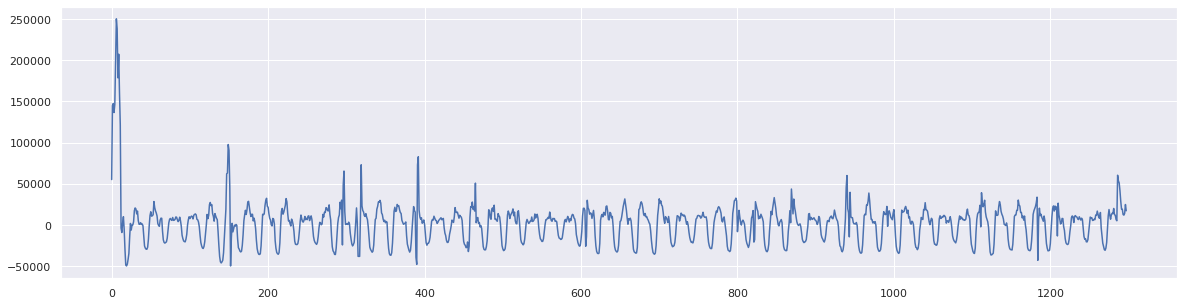

In [73]:
fig, ax = plt.subplots(1, 1)
fig.subplots_adjust(hspace=.5)
fig.set_size_inches(20, 5)
(hourly_hash_counts['count'].values - pd.Series(res.trend).fillna(0)).plot(ax=ax)

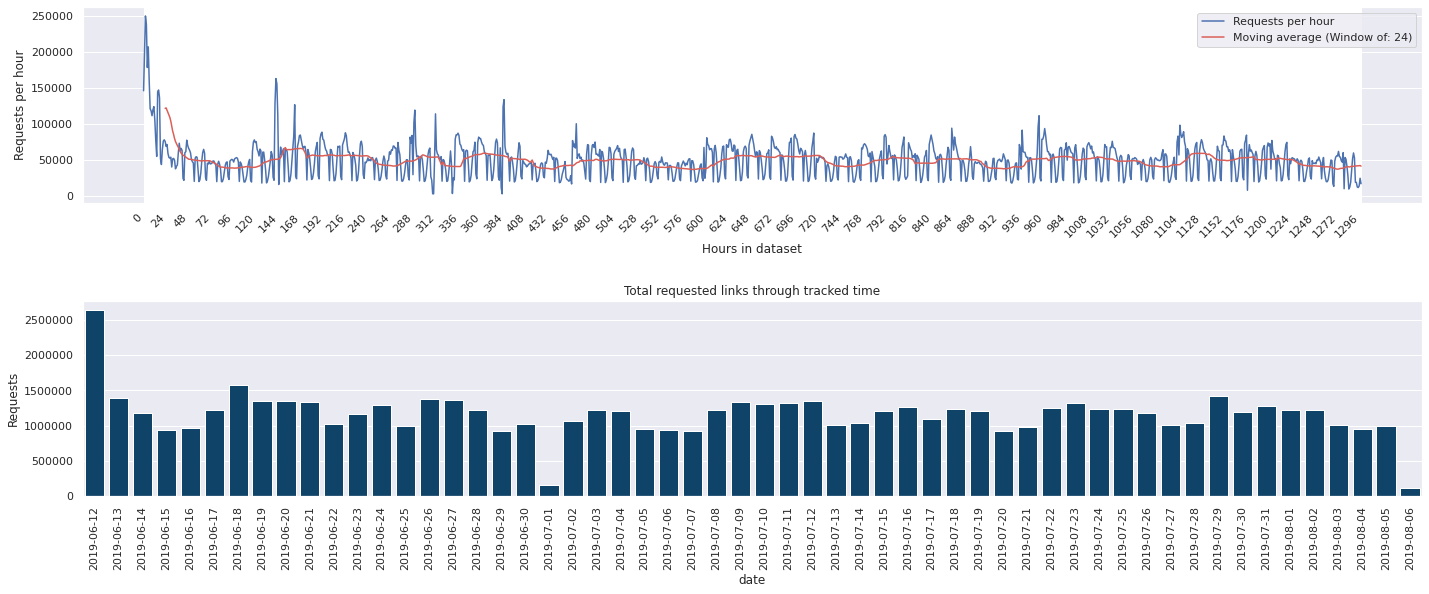

In [24]:
fig, ax = plt.subplots(2,1)
fig.subplots_adjust(hspace=.5)
fig.set_size_inches(24, 9)
g = sns.countplot(x="date", data=data, palette=sns.xkcd_palette(['prussian blue']), ax=ax[1])
labels = [item.get_text() for item in g.get_xticklabels()]
for i, label in enumerate(labels):
    labels[i] = label[:10]
g.set_xticklabels(labels, rotation=90)
g.ticklabel_format(style='plain', axis='y')
g.set_ylabel(f"Requests")
g.set_title("Total requested links through tracked time")
l = sns.lineplot(x=hourly_hash_counts.combined, y=hourly_hash_counts['count'], palette=sns.xkcd_palette(['prussian blue']), ax=ax[0], label="Requests per hour")
hourly_labels = [item.get_text() for item in l.get_xticklabels()]
for i, label in enumerate(hourly_labels):
    if i % 24 == 0:
        hourly_labels[i] = i
l.set_ylabel(f"Requests per hour")
l.set_xlabel(f"Hours in dataset")
average_window = 24
hourly_hash_counts['count'].rolling(average_window).mean().plot(ax=ax[0], color=sns.color_palette("hls", 3)[0], label=f"Moving average (Window of: {average_window})")
l.set_xticklabels(hourly_labels, rotation=45, ha="right")
#not_reoccuring_hourly['count'].plot(ax=ax[0],color=sns.color_palette("hls", 3)[2], label="Number of non-repeating requests")
ax[0].legend()
fig.savefig('../../plots/text-plots/1-analysis-series.pdf')

In [22]:
data_ndt = data.groupby(['date','hours','minutes','seconds']).count()
data_ndt = data_ndt.drop(columns=['hash','dayofweek'])
data_ndt.columns = ['count']
data_ndt = data_ndt.reset_index().groupby(['date','hours','minutes']).sum().drop(columns=['seconds'])
data_ndt = data_ndt.reset_index().groupby(['date','hours']).sum().drop(columns=['minutes'])
data_ndt = data_ndt.reset_index()
data_ndt['hours'] = data_ndt['hours'].apply(str) +':00:00'
data_ndt['ndt'] = data_ndt['date'].dt.strftime('%Y-%m-%d') + '-' + data_ndt['hours']
data_ndt = data_ndt.drop(columns=['date','hours'])
data_ndt = data_ndt.set_index('ndt')

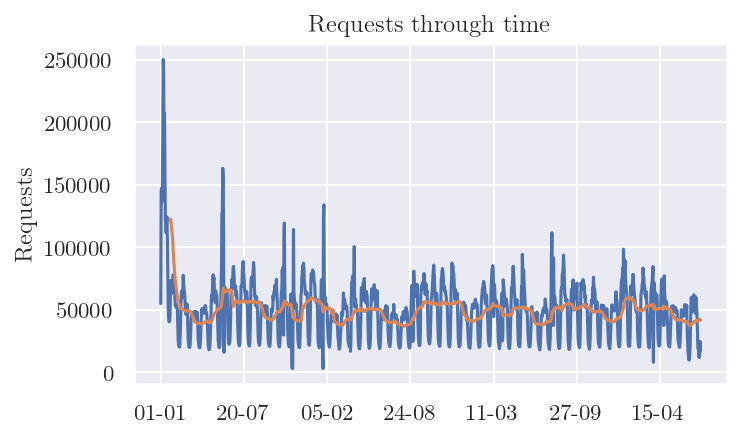

In [71]:
fig, ax = plt.subplots(1,1, dpi=150)
fig.set_size_inches(w=5.10686, h=3.)
data_ndt.plot(ax=ax)
ax.set_title("Requests through time")
ax.legend(["Requests"])
ax.set_ylabel("Requests")
data_ndt.rolling(24).mean().plot(ax=ax)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.set_xlabel("")
ax.get_legend().remove()
fig.savefig('../../plots/text-plots/1-analysis-series.pgf')

In [ ]:
fig, ax = plt.subplots(1,1)
fig.subplots_adjust(hspace=.5)
fig.set_size_inches(24, 9)
l = sns.lineplot(x=data_ndt.index, y=data_ndt['count'], palette=sns.xkcd_palette(['prussian blue']), ax=ax, label="Requests per hour")
#hourly_labels = [item.get_text() for item in l.get_xticklabels()]
#for i, label in enumerate(hourly_labels):
#    if i % 24 == 0:
#        hourly_labels[i] = i
l.set_ylabel(f"Requests per hour")
l.set_xlabel(f"Hours in dataset")
average_window = 24
data_ndt['count'].rolling(average_window).mean().plot(ax=ax[0], color=sns.color_palette("hls", 3)[0], label=f"Moving average (Window of: {average_window})")
ax[0].legend()
#fig.savefig('../../plots/text-plots/1-analysis-series.pdf')

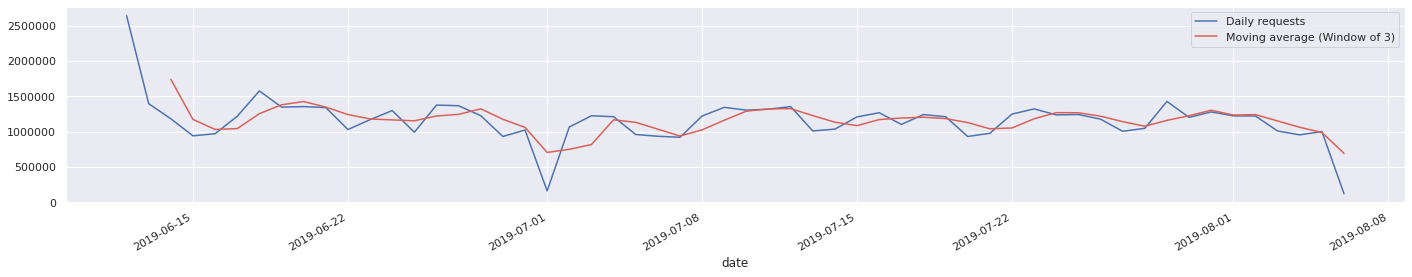

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 4)
g = sns.lineplot(x=daily_size.index, y=daily_size.values, palette=sns.color_palette("hls", 2)[1], label="Daily requests")
g.ticklabel_format(style='plain', axis='y')
average_window = 3
daily_size.rolling(average_window).mean().plot(ax=ax, color=sns.color_palette("hls", 3)[0], label=f"Moving average (Window of {average_window})")
ax.legend()
#g.set_xticklabels([])
#g.set_ylabel(f"Requests per hour")
#g.set_xlabel(f"Hours in dataset")

### Ranges of requests per item

In [24]:
hash_counts_groups

group    count
0              (0, 1]  1194581
1            (1, 100]   583229
2         (100, 1000]     9330
3       (1000, 10000]     4233
4      (10000, 25000]      313
5      (25000, 50000]       41
6     (50000, 100000]        7
7  (100000, 20000000]       22

### Non-reoccuring requests

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 4)
g = sns.lineplot(x=not_reoccuring_hourly.combined, y=not_reoccuring_hourly['count'],ax=ax, palette=sns.xkcd_palette(['prussian blue']), label="Non-reoccuring requests per hour")
g.set_xticklabels(hourly_labels, rotation = 45, ha="right")
g.set_title("Total non-reoccuring requested links through tracked time")
g.set_ylabel(f"Requests per hour")
g.set_xlabel(f"Hours in dataset")

Text(0.5, 0, 'Hours in dataset')

Text(0.5, 1.0, 'Total non-reoccuring requested links through tracked time')

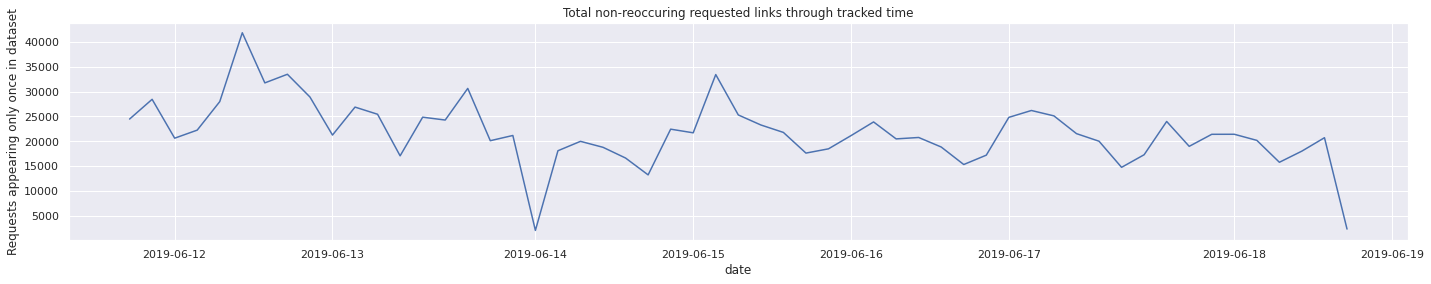

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 4)
g = sns.lineplot(x=not_reoccuring_daily.date, y=not_reoccuring_daily['count'], palette=sns.xkcd_palette(['prussian blue']), ax=ax)
g.set_xticklabels(labels)
g.ticklabel_format(style='plain', axis='y')
g.set_ylabel(f"Requests appearing only once in dataset")
g.set_title("Total non-reoccuring requested links through tracked time")

In [26]:
not_reoccuring_daily.mean()

count    21719.654545
dtype: float64

In [34]:
not_reoccuring_100 =  hash_counts[hash_counts <= 100]
not_reoccuring_daily_indexes_100 = hash_count_by_day.reset_index().hash.isin(not_reoccuring_100.index)
# Filtered requests counts hourly/daily
not_reoccuring_daily_100 = hash_count_by_day.reset_index()[not_reoccuring_daily_indexes_100]
not_reoccuring_daily_100 = not_reoccuring_daily_100.groupby('date').sum().reset_index()
not_reoccuring_daily_100.columns = ['date','count']

In [35]:
not_reoccuring_daily_100.mean()

count    76272.0
dtype: float64

In [36]:
not_reoccuring_daily_100.sum()

count    4271232
dtype: int64

## Requests per day of the week ##
This section explores the nature of the dataset during days of the week

In [18]:
def day_to_str(day):
    return {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday',
    }[day]

In [19]:
def plot_day(day, color, daily_mean, daily_max, daily_min, ax):
    d_mean = daily_mean.query(f'dayofweek == {day}')
    d_min = daily_min.query(f'dayofweek == {day}')
    d_max = daily_max.query(f'dayofweek == {day}')
    ax.plot(d_mean['hours'], d_mean['mean'], color=color, label=day_to_str(day))
    ax.plot(d_max['hours'], d_max['max'], alpha=0.3, color=color)
    ax.plot(d_min['hours'], d_min['min'], alpha=0.3, color=color)
    ax.fill_between(d_mean['hours'], d_mean['mean'], d_max['max'], alpha=0.2, facecolor=color, interpolate=True)
    ax.fill_between(d_mean['hours'], d_mean['mean'], d_min['min'], alpha=0.2, facecolor=color, interpolate=True)
    ax.xaxis.set_ticks(range(0, 24, 2))
    ax.set_xlabel('Hours')
    ax.set_ylabel('Requests')
    ax.set_title(f'Min, Mean, Max requests on {day_to_str(day)} (Aggregated by hour)')

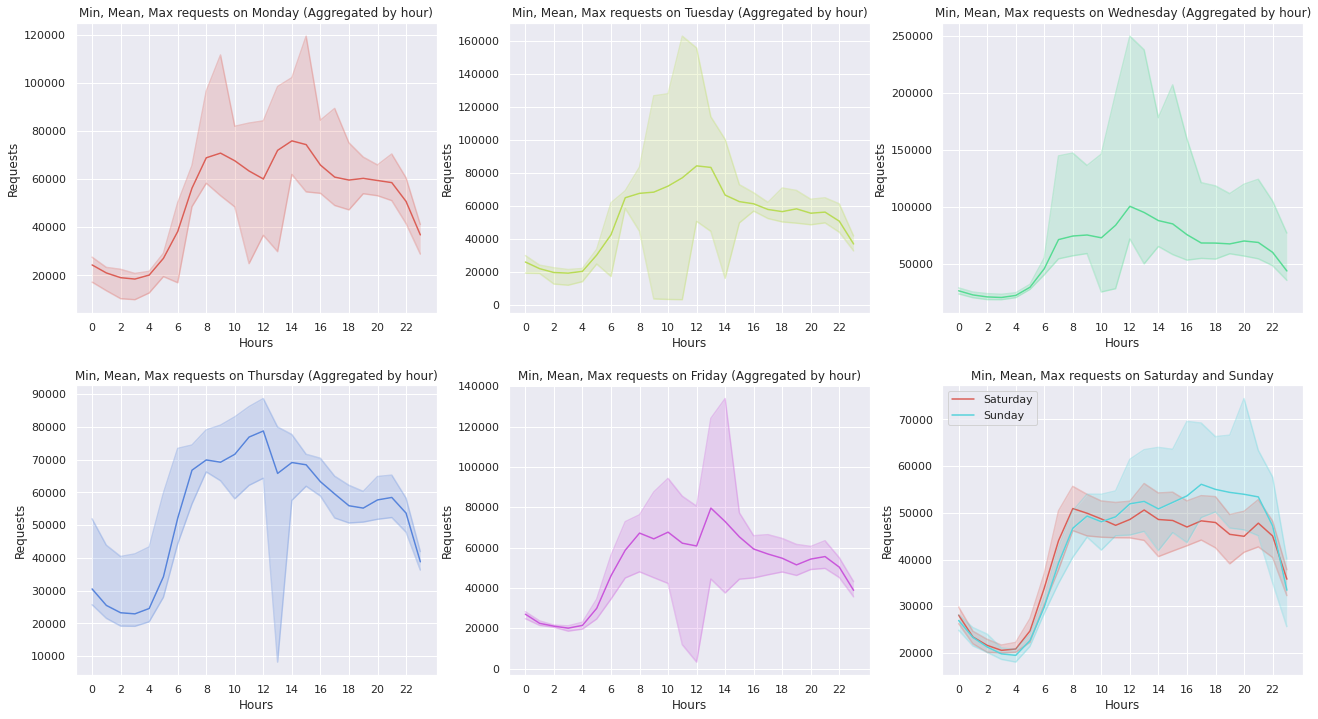

In [32]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(22,12)
fig.subplots_adjust(hspace=.25)
plot_day(0, sns.color_palette("hls", 5)[0], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[0][0])
plot_day(1, sns.color_palette("hls", 5)[1], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[0][1])
plot_day(2, sns.color_palette("hls", 5)[2], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[0][2])
plot_day(3, sns.color_palette("hls", 5)[3], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[1][0])
plot_day(4, sns.color_palette("hls", 5)[4], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[1][1])
#
plot_day(5, sns.color_palette("hls", 2)[0], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[1][2])
plot_day(6, sns.color_palette("hls", 2)[1], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[1][2])
ax[1][2].set_title(f'Min, Mean, Max requests on {day_to_str(5)} and {day_to_str(6)}')
ax[1][2].legend()

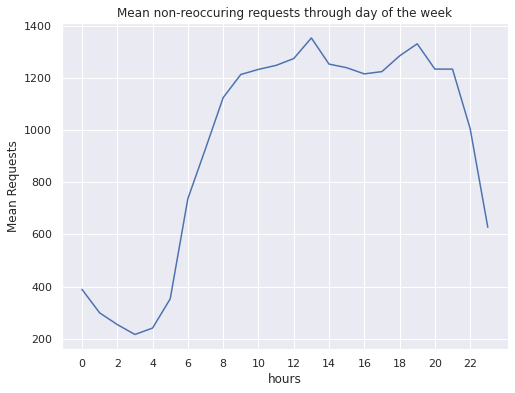

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.xaxis.set_ticks(range(0, 24, 2))
ax.set_xlabel('Hours')
ax.set_ylabel('Mean Requests')
ax.set_title(f'Mean non-reoccuring requests through day of the week')
sns.lineplot(data=not_reoccuring_hourly.groupby(['hours']).mean(), color=sns.color_palette("hls", 2)[0], ax=ax, label="Not reoccuring requests mean")
#sns.lineplot(x=week_mean['hours'], y=week_mean['mean'], color=sns.color_palette("hls", 2)[1], ax=ax, label="All requests mean")
ax.get_legend().remove()

## Weekend and working week comparison ##

In [80]:
fig, ax = plt.subplots(dpi=150)
fig.set_size_inches(w=5.10686, h=3.25)

ax.plot(weekday_mean.index, weekday_mean['mean'], color=sns.color_palette("hls", 2)[0], label='Working week Mean')
ax.plot(weekend_mean.index, weekend_mean['mean'], color=sns.color_palette("hls", 2)[1], label='Weekend Mean')
ax.xaxis.set_ticks(range(0, 24, 2))
ax.set_xlabel('Hours')
ax.set_ylabel('Mean Requests')
ax.set_title(f'Mean requests comparison on Weekend/Weekday (Aggregated by hour)')
ax.legend()
fig.savefig('../../plots/text-plots/1-daily-mean.pgf')

### Week graph overlay ###

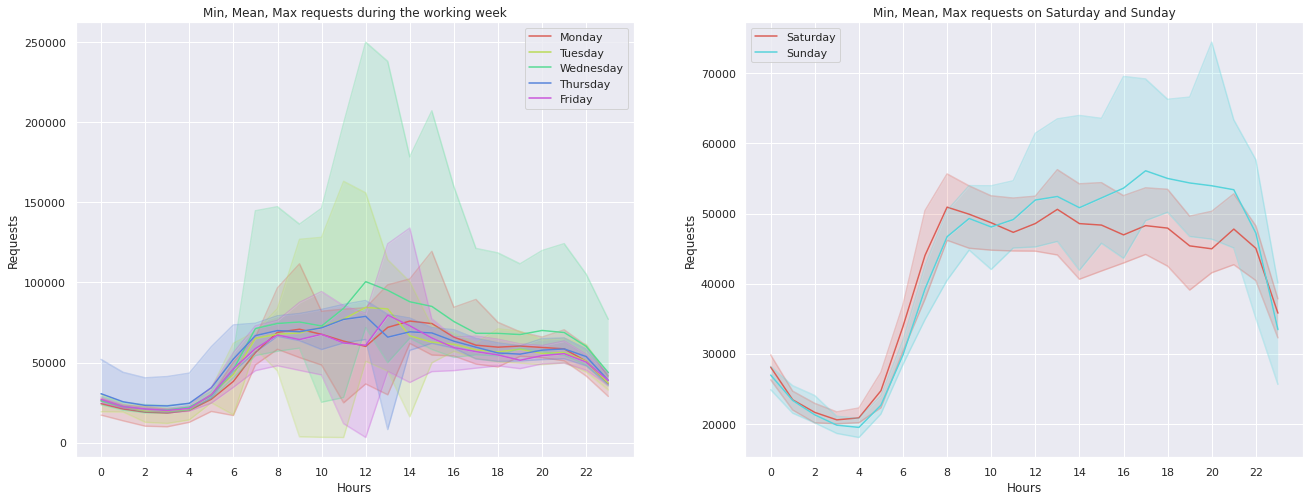

In [35]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(22,8)
plot_day(0, sns.color_palette("hls", 5)[0], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[0])
plot_day(1, sns.color_palette("hls", 5)[1], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[0])
plot_day(2, sns.color_palette("hls", 5)[2], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[0])
plot_day(3, sns.color_palette("hls", 5)[3], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[0])
plot_day(4, sns.color_palette("hls", 5)[4], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[0])
ax[0].set_title(f'Min, Mean, Max requests during the working week')
ax[0].legend()
#
plot_day(5, sns.color_palette("hls", 2)[0], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[1])
plot_day(6, sns.color_palette("hls", 2)[1], daily_seasonality_mean, daily_seasonality_max, daily_seasonality_min, ax[1])
ax[1].set_title(f'Min, Mean, Max requests on {day_to_str(5)} and {day_to_str(6)}')
ax[1].legend()

## Dropoff in popularity amongs most popular requests ##
This section explores how sharp is the decline amongst the most popular hashes (requests)

Text(0.5, 1.0, 'Dropoff in 35 most requested links')

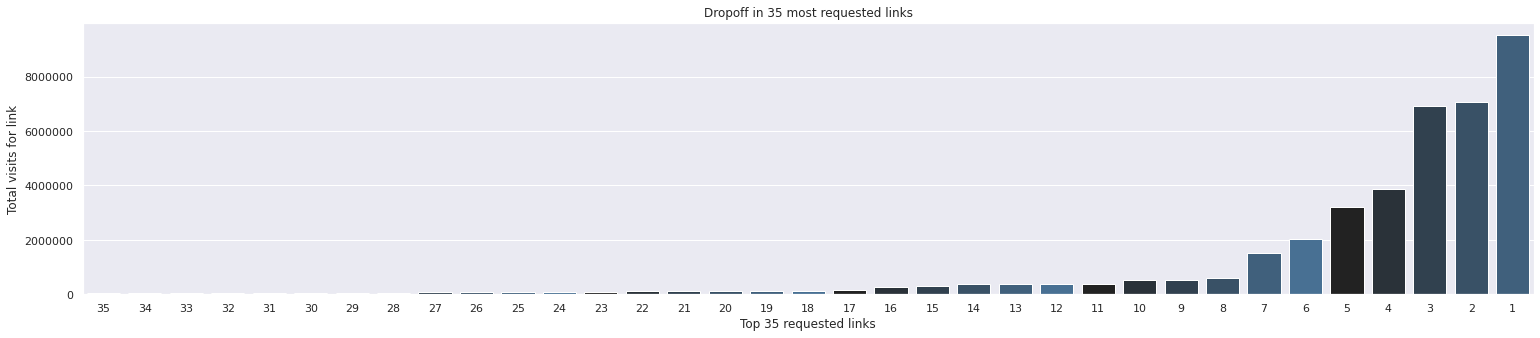

In [36]:
dropoff_number = 35
visits_dropoff = hash_counts.tail(dropoff_number)

plt.figure(figsize=(26, 5))
g = sns.barplot(x=visits_dropoff.index, y=visits_dropoff.values, palette=sns.dark_palette("muted blue", input="xkcd"))
g.ticklabel_format(style='plain', axis='y')
g.set_xticklabels(reversed(range(1, dropoff_number+1)))
g.set_ylabel(f"Total visits for link")
g.set_xlabel(f"Top {dropoff_number} requested links")
g.set_title(f"Dropoff in {dropoff_number} most requested links")

Text(0.5, 1.0, 'Dropoff in range of requested links 60:600')

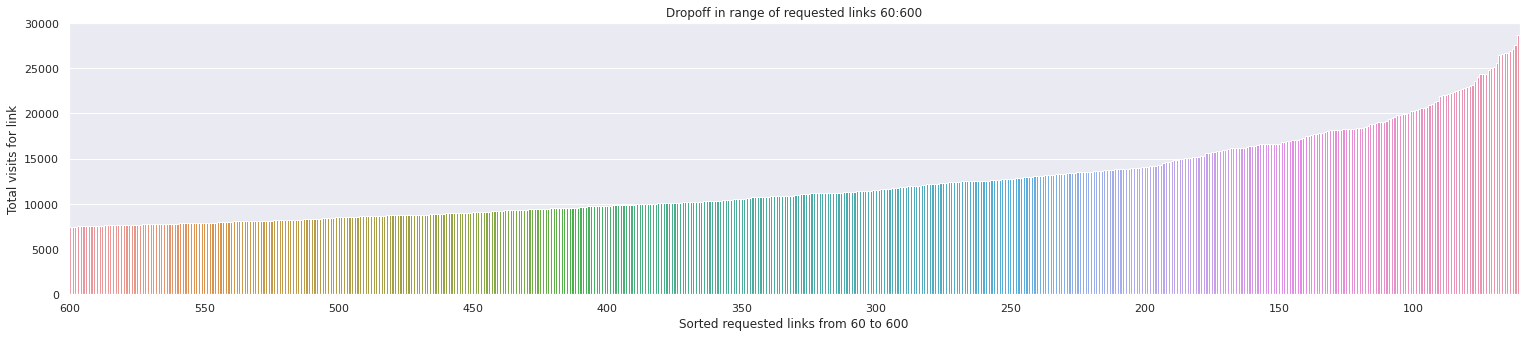

In [37]:
range_start = 60
range_end = 600

plt.figure(figsize=(26, 5))
g = sns.barplot(x=hash_counts.index[-range_end:-range_start], y=hash_counts.values[-range_end:-range_start])
g.ticklabel_format(style='plain', axis='y')
labels = list(reversed(range(range_start, range_end+1)))
for i,val in enumerate(labels):
    if(i % 50 != 0):
        labels[i] = ''
g.set_xticklabels(labels)
g.set_ylabel(f"Total visits for link")
g.set_xlabel(f"Sorted requested links from {range_start} to {range_end}")
g.set_title(f"Dropoff in range of requested links {range_start}:{range_end}")

In [33]:
plt.figure(figsize=(26, 5))
p = plt.plot(range(0, len(hash_counts.unique())), hash_counts.unique())
#p.ticklabel_format(style='plain', axis='y')

## Autocorrelation ##

In [28]:
print(f"Autocorrelation for lag 1: {hourly_count['count'].autocorr()}")

Autocorrelation for lag 1: 0.8737213810361327


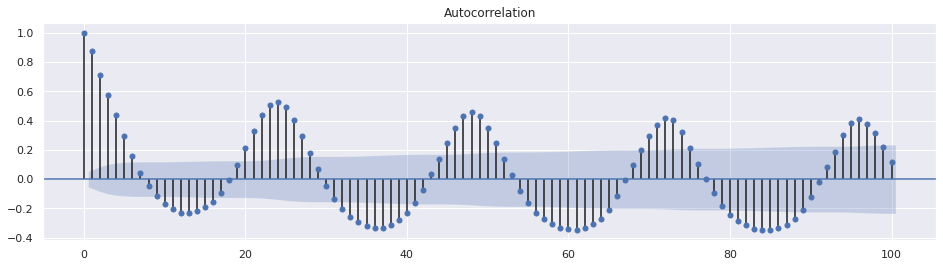

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
sm.graphics.tsa.plot_acf(hourly_count, lags=100, ax=ax)
plt.show()

In [83]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
sm.graphics.tsa.plot_pacf(hourly_count, lags=100, ax=ax)
plt.show()

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
#sm.graphics.tsa.plot_acf(hourly_hash_counts.drop(columns=['date','hours']).set_index(['combined']), lags=1200, ax=ax)
pd.plotting.autocorrelation_plot(hourly_count, ax=ax)
pd.plotting.
plt.show()

## Lag plot ##

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


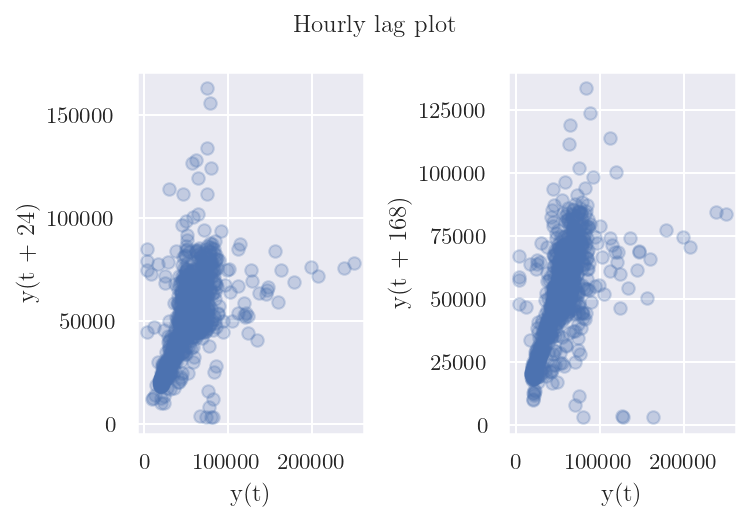

In [23]:
fig, ax = plt.subplots(1, 2, tight_layout=True, dpi=150)
fig.set_size_inches(w=5.10686, h=3.5)#7.75
fig.suptitle("Hourly lag plot")
pd.plotting.lag_plot(hourly_hash_counts.drop(columns=['date','hours']).set_index(['combined']), alpha=0.25, lag=24, ax=ax[0])
pd.plotting.lag_plot(hourly_hash_counts.drop(columns=['date','hours']).set_index(['combined']), alpha=0.25, lag=168, ax=ax[1])
fig.savefig('../../plots/text-plots/1-lag-plot.pgf')

# Sandbox #
Notebook section dedicated to ad-hoc or experimental plots and queries

In [38]:
hash_counts.tail()

4e395735b02fc10b9ffc1ca9c28c984f    3201263
d03517f419b520bed290a38e43f578d5    3854028
2221cfb0cf91af74b0122f102e6ae3ff    6907003
e93fa2ab48a1d7f395028dbb379c406b    7081402
60940bbf1a3b82169641ba159686a6ca    9508593
Name: hash, dtype: int64

In [39]:
print(hash_counts.reset_index().iloc[0])
print(hash_counts.reset_index().iloc[1000])
print(hash_counts.reset_index().iloc[100000])
print(hash_counts.reset_index().iloc[-50000])
print(hash_counts.reset_index().iloc[-1000])
print(hash_counts.reset_index().iloc[-150])
print(hash_counts.reset_index().iloc[-30])
print(hash_counts.reset_index().iloc[-1])

index    eb2a738dcc1c6fa67c1c73bbfaa233a7
hash                                    1
Name: 0, dtype: object
index    a706a1640d93be43be9da5af12403552
hash                                    1
Name: 1000, dtype: object
index    cc5745ea5a09ec494d68dffbdaebf889
hash                                    1
Name: 100000, dtype: object
index    3e552918cc149f3452819193bb2e4310
hash                                   13
Name: 1741756, dtype: object
index    08d7de32c0d0734c5d4c94a62b5169b4
hash                                 5059
Name: 1790756, dtype: object
index    60a8863c06fb37039ab542ba5450ebd7
hash                                16633
Name: 1791606, dtype: object
index    3fda7f1f0e3fedeceb98ccd934225e2e
hash                                48210
Name: 1791726, dtype: object
index    60940bbf1a3b82169641ba159686a6ca
hash                              9508593
Name: 1791755, dtype: object


In [4]:
def plot_hash_daily(hash_id, daily_count, ax, color, date_range):
    daily_count_modified = daily_count[hash_id].reset_index()
    daily_count_modified.columns = ['date', 'dailycount']
    for date in date_range:
        if not date in daily_count[hash_id].index:
            daily_count_modified = daily_count_modified.append({'date':date, 'dailycount':0}, ignore_index=True)
    daily_count_modified.sort_values(['date'], inplace=True)
    ax.plot(daily_count_modified.date, daily_count_modified.dailycount, color=color)
    ax.set(xlim=(date_range[0], date_range[-1]))
    #ax.set_xticklabels(date_range, rotation=90)
    # Lines for easy orientation/comparison
    plt.axhline(y=10000, color='g', linestyle='--')
    plt.axhline(y=25000, color='g', linestyle='--')
    plt.axhline(y=50000, color='g', linestyle='--')
    plt.axhline(y=100000, color='g', linestyle='--')

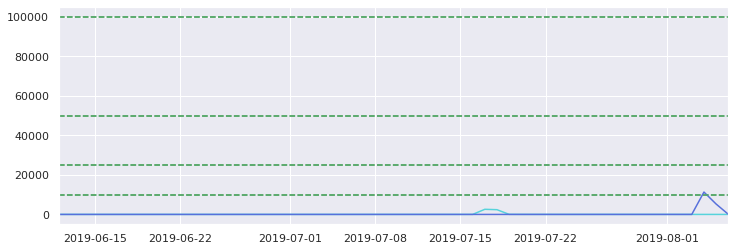

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
#plot_hash_daily('b3f31145934a71132cc9cafc27e5990a', hash_count_by_day, ax, sns.color_palette("hls", 8)[0], date_range)
#plot_hash_daily('636ca3cfe30715b4984de3e171b24008', hash_count_by_day, ax, sns.color_palette("hls", 8)[1], date_range)
#plot_hash_daily('4d26c54715d2ca04fb1d960769be32b6', hash_count_by_day, ax, sns.color_palette("hls", 8)[2], date_range)
#plot_hash_daily('d61421abc25628943e0119a31286e42e', hash_count_by_day, ax, sns.color_palette("hls", 8)[3], date_range)
plot_hash_daily('421dcd1d0e290d820b394be955f9f45a', hash_count_by_day, ax, sns.color_palette("hls", 8)[4], date_range)
plot_hash_daily('60a8863c06fb37039ab542ba5450ebd7', hash_count_by_day, ax, sns.color_palette("hls", 8)[5], date_range)
#plot_hash_daily('3fda7f1f0e3fedeceb98ccd934225e2e', hash_count_by_day, ax, sns.color_palette("hls", 8)[6], date_range)
#plot_hash_daily('60940bbf1a3b82169641ba159686a6ca', hash_count_by_day, ax, sns.color_palette("hls", 8)[7], date_range)

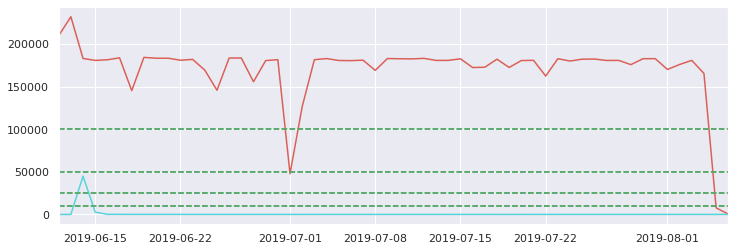

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
plot_hash_daily('60940bbf1a3b82169641ba159686a6ca', hash_count_by_day, ax, sns.color_palette("hls", 2)[0], date_range)
#plot_hash_daily('e93fa2ab48a1d7f395028dbb379c406b', hash_count_by_day, ax, 'green', date_range)
#plot_hash_daily('2221cfb0cf91af74b0122f102e6ae3ff', hash_count_by_day, ax, 'blue', date_range)
#plot_hash_daily('d03517f419b520bed290a38e43f578d5', hash_count_by_day, ax, 'purple', date_range)
plot_hash_daily('3fda7f1f0e3fedeceb98ccd934225e2e', hash_count_by_day, ax, sns.color_palette("hls", 2)[1], date_range)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 8)
hash_count_by_hour['60940bbf1a3b82169641ba159686a6ca'].plot(ax=ax)